In [1]:
#Import dataset
import kagglehub
import shutil
from google.colab import files
path = kagglehub.dataset_download("camnugent/california-housing-prices")
print("Path to dataset files:", path)
shutil.make_archive('dataset', 'zip', path)
shutil.unpack_archive('./dataset.zip', './', 'zip')
print("Dataset downloaded!")


100%|██████████| 400k/400k [00:00<00:00, 43.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/camnugent/california-housing-prices/versions/1


Dataset downloaded!


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, PCA, OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.mllib.stat import Statistics
from time import time
import seaborn as sns

spark = SparkSession.builder \
    .appName("KMeans Clustering") \
    .getOrCreate()

#Load dataset
data_path = "./housing.csv"  # Replace with your actual dataset path
data = spark.read.csv(data_path, header=True, inferSchema=True)
data.show(n=10, truncate=False)
print(f"Number of rows: {data.count()}")

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|-122.23  |37.88   |41.0              |880.0      |129.0         |322.0     |126.0     |8.3252       |452600.0          |NEAR BAY       |
|-122.22  |37.86   |21.0              |7099.0     |1106.0        |2401.0    |1138.0    |8.3014       |358500.0          |NEAR BAY       |
|-122.24  |37.85   |52.0              |1467.0     |190.0         |496.0     |177.0     |7.2574       |352100.0          |NEAR BAY       |
|-122.25  |37.85   |52.0              |1274.0     |235.0         |558.0     |219.0     |5.6431       |341300.0          |NEAR BAY       |
|-122.25  |37.85   |52.0          

**K-Means++ execution on raw data**

First we study how k-means++ handles clustering on raw data, without any feature engineering applied. We study the best k with Silhouette and Elbow methods. We plot the clustering of the points using the most relevant two dimensions extracted with PCA.
We do also an ablation study to undestand exactly what two features are the most relevant: this is done by removing from the vector some feature each time and undestand the impact on the final clustering graph.

In [ ]:
#Vectorize features, otherwise we cannot call KMeans on the dataframe
#The operation is performed on pure raw data without filtering values, imputing values or removing any columns, we need
#to index ocean_proximity for NN to work though.
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed")
indexed_data = indexer.fit(data).transform(data)
indexed_data = indexed_data.drop('ocean_proximity')

assembler = VectorAssembler(inputCols=[ #we remove one feature at a time here to test then how the clustering on raw data is affected and find most important ones
        "longitude",
        "latitude",
        "housing_median_age",
        "total_rooms", # total rooms is the second most important dimension
        "total_bedrooms",
        "population",
        "households",
        "median_income",
        "median_house_value", #median_house_value is the most important dimension with the highest variance
        "ocean_proximity_indexed"
    ], outputCol="features", handleInvalid="skip")
vectorized_data = assembler.transform(indexed_data)
vectorized_data = vectorized_data.drop('longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms','population','households','median_income','median_house_value','ocean_proximity_indexed')

vectorized_data.show(n=1, truncate=False)
print(vectorized_data.count())

+----------------------------------------------------------------+
|features                                                        |
+----------------------------------------------------------------+
|[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0]|
+----------------------------------------------------------------+
only showing top 1 row

20433


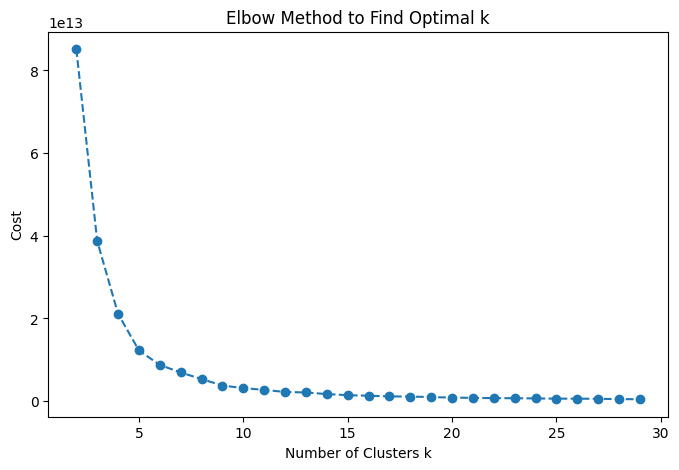

In [ ]:
#Apply elbow method: calculate and plot elbow curve and choose the "elbow" value
cost = []
k_values = range(2, 30) #we don't do 1 cluster it's useless

for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k)
    model = kmeans.fit(vectorized_data)
    cost.append(model.summary.trainingCost)

plt.figure(figsize=(8, 5))
plt.plot(k_values, cost, marker='o', linestyle='--')
plt.xlabel('Number of Clusters k')
plt.ylabel('Cost')
plt.title('Elbow Method to Find Optimal k')
plt.savefig('./Elbow method plot')
plt.show()

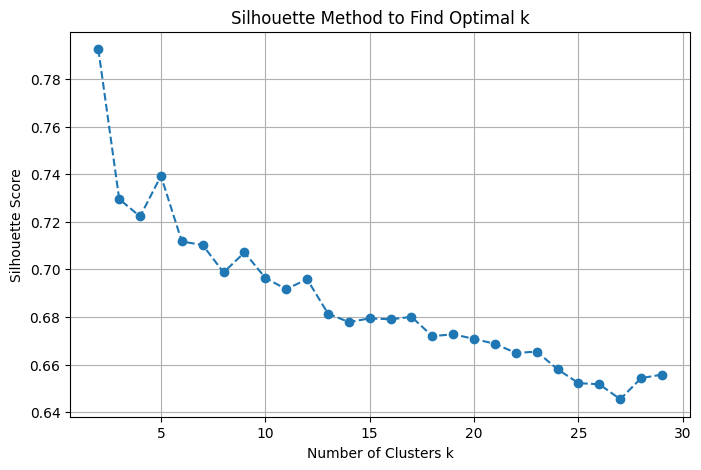

In [ ]:
#Use Silhouette method: works by computing silhouette score for every value of k and plotting it. We take best score k.
sil_scores = []
k_values = range(2, 30)

for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k)
    model = kmeans.fit(vectorized_data)
    clustered_data = model.transform(vectorized_data)
    evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName='silhouette')
    silhouette_score = evaluator.evaluate(clustered_data)
    sil_scores.append(silhouette_score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method to Find Optimal k')
plt.grid(True)
plt.savefig('./Silhouette_method_plot.png')
plt.show()

#Silhouette = (cohesion-separation)/max(cohesion,separation)
#cohesion = average distance of the point from other points in its cluster
#separation = average distance of point from points in the nearest cluster that is not the point's cluster

**Considerations on the best value for k**

Silhouette score is very high for k=2 and k=5, however the elbow method tells us that the calculated sum of squared distances within cluster is very high for these values (even with k=5), and as such we need to look for higher values for k. In any case though, the problem with the raw data is an extremely high WCSS (in the order of trilions).

Time elapsed: 16.394270658493042


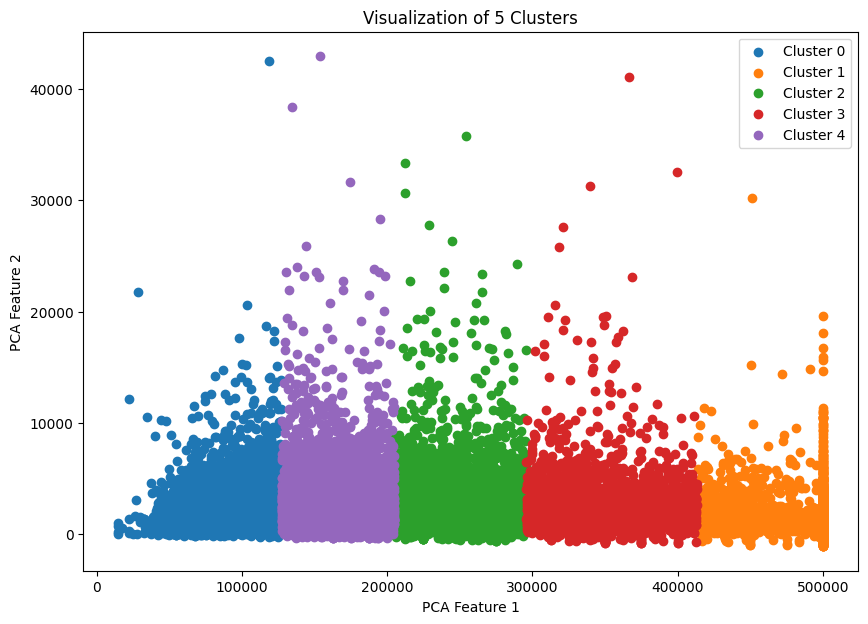

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.999527692358853
Feature Contributions: [-7.87918885e-07  5.16808435e-05]


Principal Component 2:
Explained Variance: 0.0004502535926210399
Feature Contributions: [-2.67679718e-06 -3.38354098e-05]


Clustering Performance Metrics:
Silhouette Score: 0.7394874639813255
Within-Cluster Sum of Squares (WCSS): 12267178342826.826


In [ ]:
#Works again with vectorized_data
k = 5
kmeans = KMeans(featuresCol="features", k=k)

start = time()
model = kmeans.fit(vectorized_data) #k-means++ execution
end = time()
print(f"Time elapsed: {end-start}")

#Add the cluster labels to the dataset
clustered_data = model.transform(vectorized_data)

#Perform PCA to reduce the "features" column to 2 dimensions
#PCA is an algorithm using Singular Value Decomposition to get the two most important dimensions and preserve variance
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(clustered_data)
pca_result = pca_model.transform(clustered_data)
pca_result = pca_result.withColumn("pca_array", vector_to_array("pca_features"))

#Extract the first two components into separate columns
#We reduce the dimensions to two in order to plot the points on a 2D space
pca_df = pca_result.select(
    col("pca_array")[0].alias("x"),
    col("pca_array")[1].alias("y"),
    "prediction"  #thes are cluster labels
).toPandas()

plt.figure(figsize=(10, 7))
for cluster in range(k):
    cluster_points = pca_df[pca_df["prediction"] == cluster]
    plt.scatter(cluster_points["x"], cluster_points["y"], label=f"Cluster {cluster}")

plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title(f"Visualization of {k} Clusters")
plt.legend()
plt.savefig('./Cluster visualization')
plt.show()

pca_components = pca_model.pc

#Convert components to a numpy array for easier interpretation
pca_components_array = pca_components.toArray()
explained_variance = pca_model.explainedVariance

#Show the components and variance explained
print("PCA Components (Feature Contributions):")
for i in range(len(explained_variance)):
    print(f"Principal Component {i + 1}:")
    print(f"Explained Variance: {explained_variance[i]}")
    print(f"Feature Contributions: {pca_components_array[i]}")
    print("\n")

#Finally show the "performance" of clusteing, using sum of squared errors and silhouette scores
#Silhouette score helps us understand how well compacted clusters are
silhouette_evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
silhouette_score = silhouette_evaluator.evaluate(clustered_data)
wcss = model.summary.trainingCost
print("Clustering Performance Metrics:")
print(f"Silhouette Score: {silhouette_score}")
print(f"Within-Cluster Sum of Squares (WCSS): {wcss}")

**Exploring the Dataset**

First, let's study the dataset, starting from the number of null values. The dataset has only 207 tuples with null values, precisely in the 'total_rooms' field. These rows are few, so we can remove them without too many problems.

In [ ]:
print(f"Number of null tuples is: {data.filter(col('longitude').isNull() | col('latitude').isNull() | col('housing_median_age').isNull() | col('total_rooms').isNull() | col('total_bedrooms').isNull() | col('population').isNull() | col('households').isNull() | col('median_income').isNull() | col('ocean_proximity').isNull() | col('median_house_value').isNull()).count()}")
data.filter(col('longitude').isNull() | col('latitude').isNull() | col('housing_median_age').isNull() | col('total_rooms').isNull() | col('total_bedrooms').isNull() | col('population').isNull() | col('households').isNull() | col('median_income').isNull() | col('ocean_proximity').isNull() | col('median_house_value').isNull()).show(n=1)
print(f"Number of total_bedrooms nulls is: {data.filter(col('total_bedrooms').isNull()).count()}")
print(f"Number of empty tuples is: {data.filter((col('longitude') == '') | (col('latitude') == '') | (col('housing_median_age') == '') | (col('total_rooms') == '') | (col('total_bedrooms') == '') | (col('population') == '') | (col('households') == '') | (col('median_income') == '') | (col('ocean_proximity') == '') | (col('median_house_value') == '')).count()}")

Number of null tuples is: 207
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.16|   37.77|              47.0|     1256.0|          NULL|     570.0|     218.0|        4.375|          161900.0|       NEAR BAY|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 1 row

Number of total_bedrooms nulls is: 207
Number of empty tuples is: 0


Next, let us extract information on the elements of the dataset. As expected, we get a high correlation with total rooms, total bedrooms, population and households number. We also find a correlation between median_income and median_house value. Up until now, all of these values have sensible correlations. Latitude and longitude seem to have a high anticorrelation, which can, in theory, make sense given the space span of California (from south to north changes latitude, but it has widely different longitude). However, this could skew clustering because those two variables would both contribute to the distance dimension. The only way to test it is to decorrelate the variables.

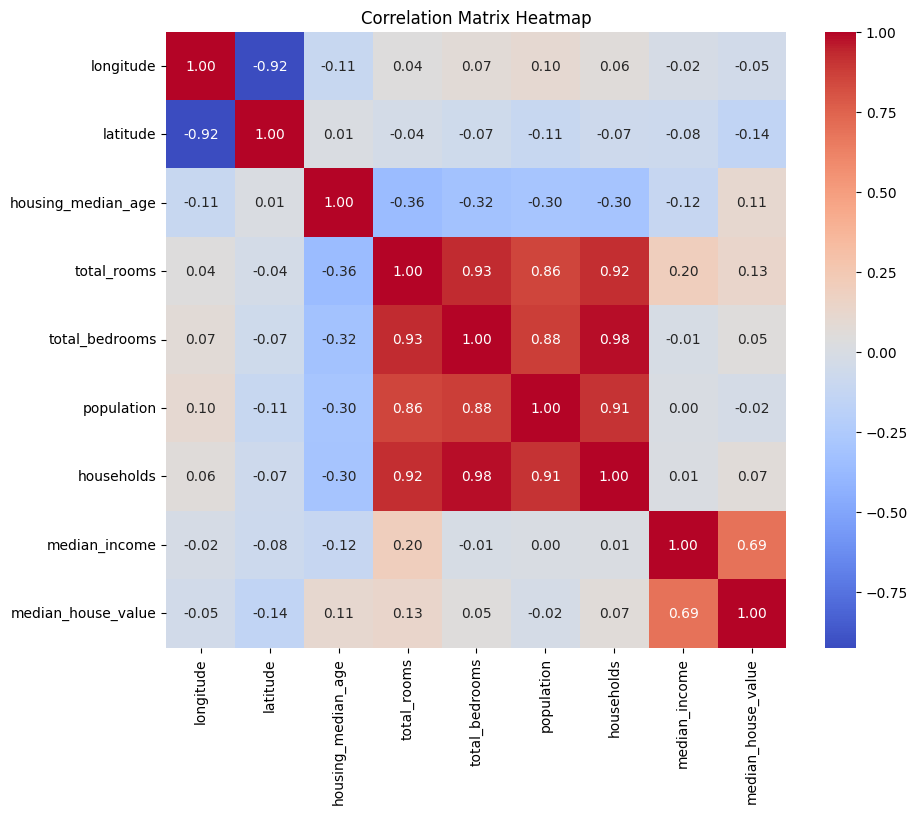

In [ ]:
#Print correlation matrix
study_data = data.drop('ocean_proximity')
pandas_df = study_data.toPandas()
correlation_matrix = pandas_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

Plotting the distribution we can see how, apart from latitude and longitude, many other graphs resemble a curve centered around the same place in its interval, and only median_house_value has a much higher variance with respect to the others, since many houses are on the pricey side. Latitude and longitude on the other hand look bimodal.

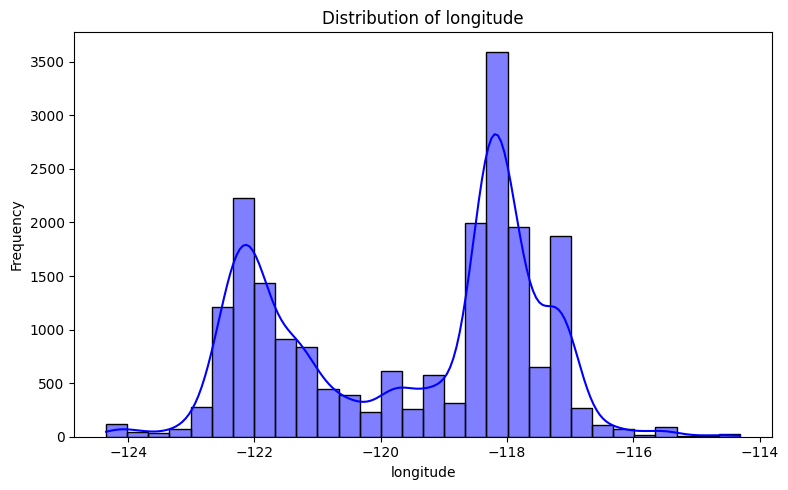

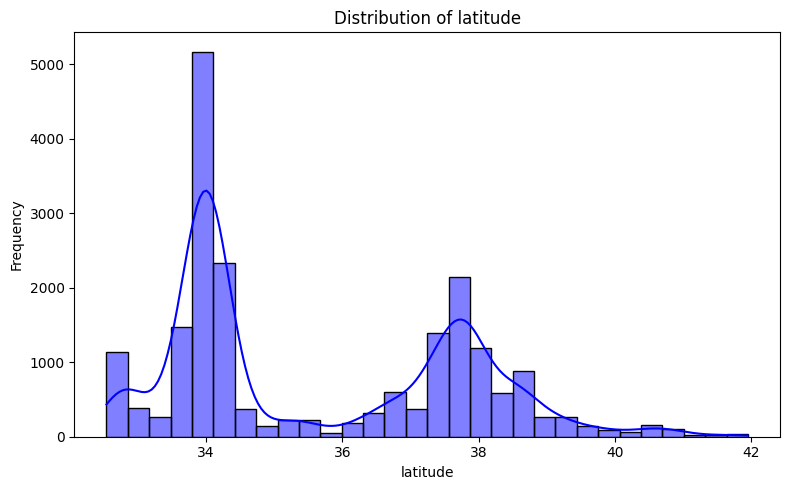

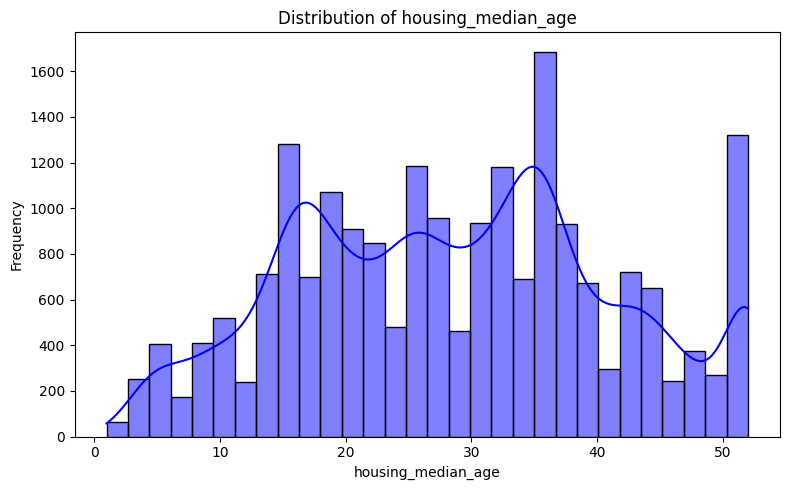

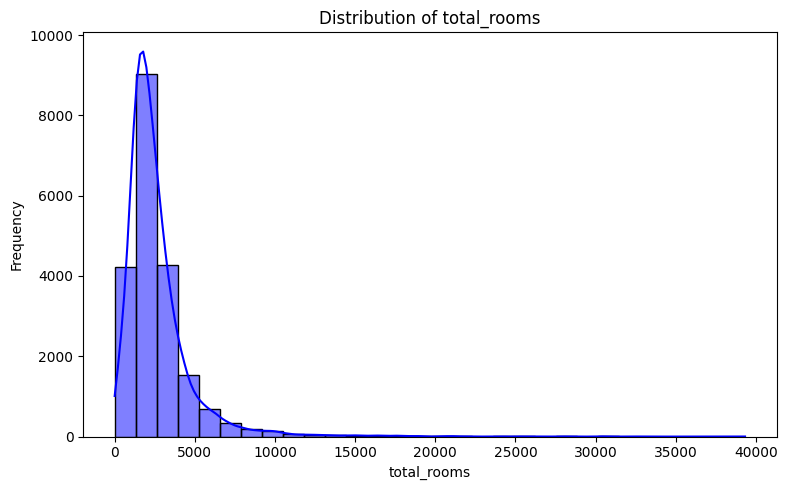

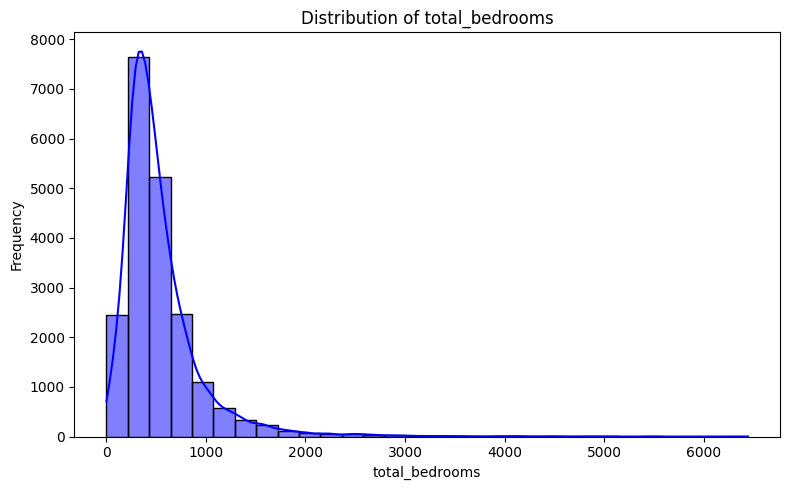

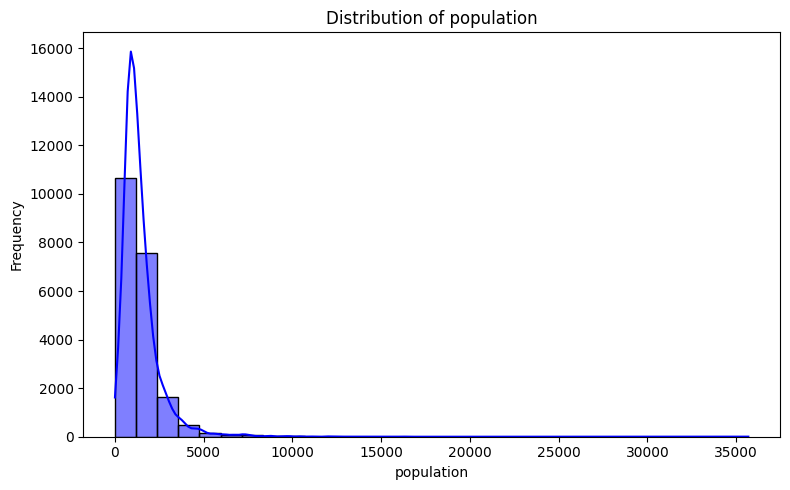

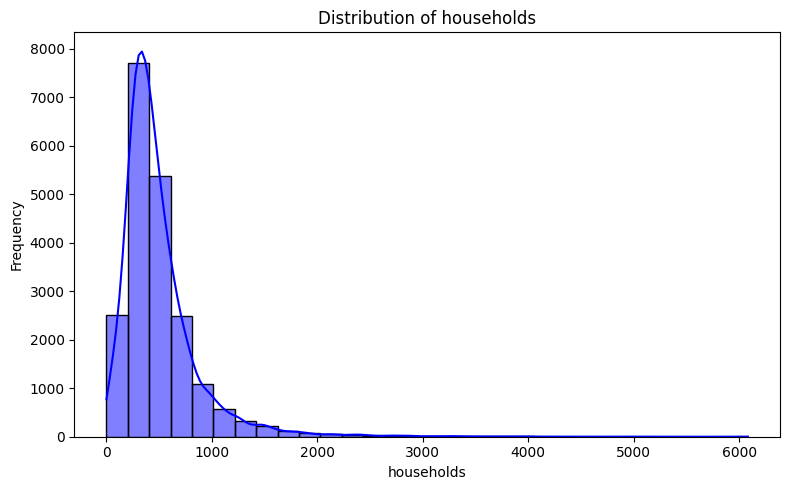

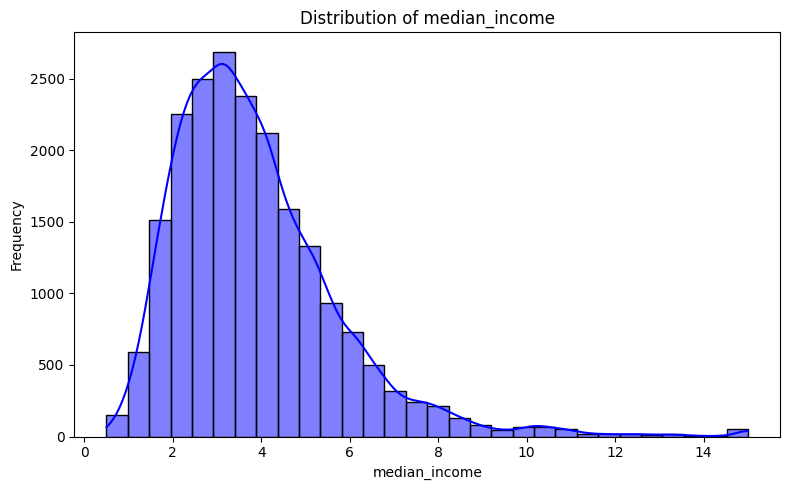

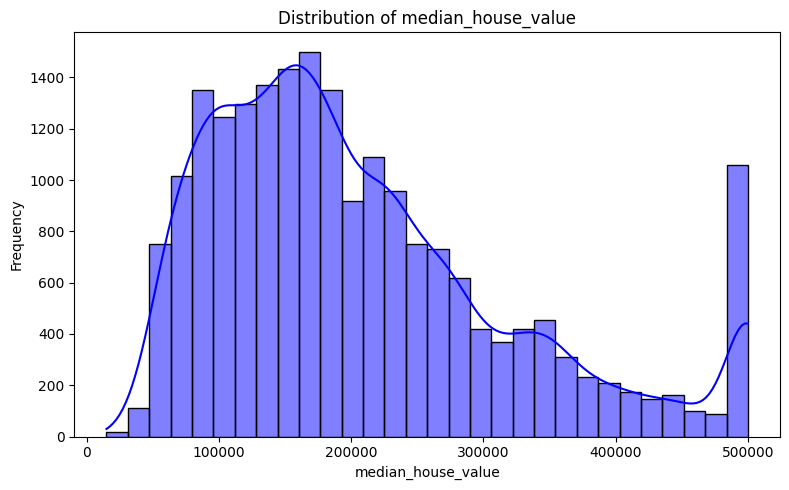

<ipython-input-40-07d5cac24dc6>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=pandas_data[column], palette="viridis", order=pandas_data[column].value_counts().index)


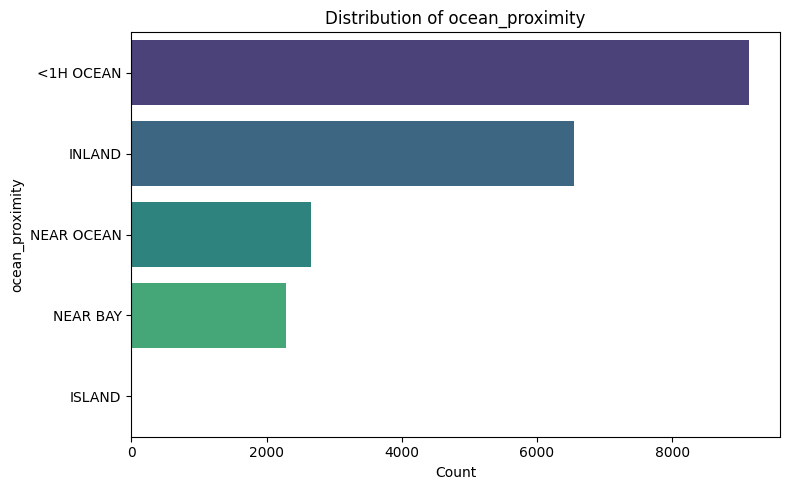

In [ ]:
#Plot distribution of ever single feature
pandas_data = data.toPandas()

for column in pandas_data.columns:
    plt.figure(figsize=(8, 5))

    if pandas_data[column].dtype in ['float64', 'int64']:
        sns.histplot(pandas_data[column], kde=True, bins=30, color='blue')
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")

    elif pandas_data[column].dtype == 'object':
        sns.countplot(y=pandas_data[column], palette="viridis", order=pandas_data[column].value_counts().index)
        plt.title(f"Distribution of {column}")
        plt.ylabel(column)
        plt.xlabel("Count")

    plt.tight_layout()
    plt.savefig(f'./{column}_distribution.png')
    plt.show()

**K-Means++ with Feature engineering on data**

In [3]:
def print_feature_engineering_results(vectorized_data, experiment_name):
  #Print elbow method and silhouette results
  cost = []
  sil_scores = []
  k_values = range(2, 30)

  for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k).setSeed(10)
    model = kmeans.fit(vectorized_data)
    cost.append(model.summary.trainingCost) #elbow method

    clustered_data = model.transform(vectorized_data)
    evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName='silhouette') #the evaluator is the class we use to extract the silhouette score
    silhouette_score = evaluator.evaluate(clustered_data)
    sil_scores.append(silhouette_score) #silhouette scores

  plt.figure(figsize=(8, 5))
  plt.plot(k_values, cost, marker='o', linestyle='--')
  plt.xlabel('Number of Clusters k')
  plt.ylabel('Cost')
  plt.title(f'Elbow Method to Find Optimal k {experiment_name}')
  plt.savefig(f'./Elbow_method_plot_{experiment_name}.png')
  plt.show()

  plt.figure(figsize=(8, 5))
  plt.plot(k_values, sil_scores, marker='o', linestyle='--')
  plt.xlabel('Number of Clusters k')
  plt.ylabel('Silhouette Score')
  plt.title(f'Silhouette Method to Find Optimal k {experiment_name}')
  plt.grid(True)
  plt.savefig(f'./Silhouette_method_plot_{experiment_name}.png')
  plt.show()

#Function to get baseline data for feature engineering, with all 10 fields and ocean_proximity as one-hot-encoded, and removing null total bedrooms
def get_fe_data(data, remove_ocean_proximity=False, remove_latitude_longitude=False):
  #First, let's remove the null rows and One-Hot encode ocean_proximity
  fe_data = data.filter(col('total_bedrooms').isNotNull())
  if remove_ocean_proximity:
    fe_data = fe_data.drop('ocean_proximity')
  else:
    indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed")
    fe_data = indexer.fit(fe_data).transform(fe_data)
    fe_data = fe_data.drop('ocean_proximity')
    encoder = OneHotEncoder(inputCol="ocean_proximity_indexed", outputCol="ocean_proximity")
    fe_data = encoder.fit(fe_data).transform(fe_data)
    fe_data = fe_data.drop("ocean_proximity_indexed")
  if remove_latitude_longitude:
    fe_data = fe_data.drop('latitude', 'longitude')
  return fe_data

#Function to assemble features vector
def assemble_features_vector(fe_data, columns=[], outputName=''):
  if columns == [] or outputName=='':
    assert outputName == '' and columns == [], "If there are any columns we need also an output name!"
    columns = fe_data.columns
    outputName = 'features'

  assembler = VectorAssembler(inputCols=columns, outputCol=outputName)
  fe_data = assembler.transform(fe_data)
  return fe_data

#Function to standardize data
def standardize_data(fe_data):
  scaler = StandardScaler(inputCol='features', outputCol='output_features', withMean=True, withStd=True)
  scaler_model = scaler.fit(fe_data)
  fe_data = scaler_model.transform(fe_data)
  fe_data = fe_data.drop('features')
  fe_data = fe_data.withColumnRenamed('output_features', 'features')

  return fe_data



#Avoids standardizing oneHot encoded data: the flow avoids standardizing the one hot encoded fields, and then rejoins them with the rest of the standardized data
def standardize_data_onehotencoded(fe_data, oneHot_Cols=[]):
  all_columns = fe_data.columns
  non_onehot_columns = [col for col in all_columns if col not in oneHot_Cols]

  assembler = VectorAssembler(inputCols=non_onehot_columns, outputCol="non_onehot_features")
  fe_data = assembler.transform(fe_data)
  scaler = StandardScaler(inputCol="non_onehot_features", outputCol="scaled_features", withMean=True, withStd=True)
  scaler_model = scaler.fit(fe_data)
  fe_data = scaler_model.transform(fe_data)

  assembler_final = VectorAssembler(  #Combine scaled features with one-hot encoded columns into a final feature vector
      inputCols=["scaled_features"] + oneHot_Cols, outputCol="features")
  fe_data = assembler_final.transform(fe_data)
  fe_data = fe_data.drop("non_onehot_features", "scaled_features")
  return fe_data


#Function to find best k dimensions with PCA, initial r is the number of dimensions we want to search through
def find_top_dimensions_PCA(fe_data, r):
  assert r > 1, "Number of chosen dimensions for PCA must be greater than 1"
  pca = PCA(k=r, inputCol="features", outputCol="pca_features")
  pca_model = pca.fit(fe_data)
  explained_variance = pca_model.explainedVariance.toArray()
  print(f"Explained variance is: {explained_variance}")
  cumulative_variance = [sum(explained_variance[:i+1]) for i in range(len(explained_variance))]
  k = next(i for i, total_variance in enumerate(cumulative_variance) if total_variance >= 0.9) + 1
  print(f"Number of components selected for 90% explained variance: {k}")
  return k

#Function to apply PCA on data and return data with features vector being the result of the PCA projections on the first r dimensiosn
def apply_PCA(fe_data, r):
  assert r > 1, "Number of chosen dimensions for PCA must be greater than 1"
  pca_final = PCA(k=r, inputCol="features", outputCol="pca_features")
  pca_final_model = pca_final.fit(fe_data)
  fe_data = pca_final_model.transform(fe_data)
  fe_data = fe_data.drop("features")
  fe_data = fe_data.withColumnRenamed('pca_features', 'features')
  return fe_data

#Print correlation matrix, provided no vectorized data field is present
def print_corr_matrix(fe_data):
  pandas_df = fe_data.toPandas()
  correlation_matrix = pandas_df.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
  plt.title("Correlation Matrix Heatmap")
  plt.show()

#Decorrelates two features using PCA
def decorrelate_features(fe_data, f1, f2):
  fe_data = assemble_features_vector(fe_data, [f1, f2], f'{f1}_{f2}_features') #assemble them together
  fe_data = fe_data.drop(f1, f2)

  pca = PCA(k=2, inputCol= f'{f1}_{f2}_features', outputCol= f'{f1}_{f2}_decorr_features') #apply pca to the assembled vector to decorrelate them
  pca_model = pca.fit(fe_data)
  fe_data = pca_model.transform(fe_data)
  fe_data = fe_data.drop(f'{f1}_{f2}_features')

  fe_data = fe_data.withColumn(f'{f1}_{f2}_arr_decorr_features', vector_to_array(col(f'{f1}_{f2}_decorr_features'))) #transform vector to array to split the features back after the decorrelation
  fe_data = fe_data.drop(f'{f1}_{f2}_decorr_features')

  fe_data = fe_data.withColumn(f1, col(f'{f1}_{f2}_arr_decorr_features')[0]) #split the features back again
  fe_data = fe_data.withColumn(f2, col(f'{f1}_{f2}_arr_decorr_features')[1])
  fe_data = fe_data.drop(f'{f1}_{f2}_arr_decorr_features')

  return fe_data

In [4]:
#Take k-means time and plot 2D graph
def plot_cluster(vectorized_data, k, experiment_name):

  spark.catalog.clearCache()

  kmeans = KMeans(featuresCol="features", k=k).setSeed(10)
  start = time()
  model = kmeans.fit(vectorized_data)
  print(f"Time elapsed: {time()-start} seconds")

  clustered_data = model.transform(vectorized_data)
  pca = PCA(k=2, inputCol="features", outputCol="pca_features")
  pca_model = pca.fit(clustered_data)
  pca_result = pca_model.transform(clustered_data)
  pca_result = pca_result.withColumn("pca_array", vector_to_array("pca_features"))

  pca_df = pca_result.select(
      col("pca_array")[0].alias("x"),
      col("pca_array")[1].alias("y"),
      "prediction"
  ).toPandas()

  plt.figure(figsize=(10, 7))
  for cluster in range(k):
      cluster_points = pca_df[pca_df["prediction"] == cluster]
      plt.scatter(cluster_points["x"], cluster_points["y"], label=f"Cluster {cluster}")

  plt.xlabel("PCA Feature 1")
  plt.ylabel("PCA Feature 2")
  plt.title(f"Visualization of {k} Clusters {experiment_name}")
  plt.legend()
  plt.savefig(f'./Cluster_visualization_{experiment_name}.png')
  plt.show()

  pca_components = pca_model.pc
  pca_components_array = pca_components.toArray()
  explained_variance = pca_model.explainedVariance

  print("PCA Components (Feature Contributions):")
  for i in range(len(explained_variance)):
      print(f"Principal Component {i + 1}:")
      print(f"Explained Variance: {explained_variance[i]}")
      print(f"Feature Contributions: {pca_components_array[i]}")
      print("\n")

  silhouette_evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
  silhouette_score = silhouette_evaluator.evaluate(clustered_data)
  wcss = model.summary.trainingCost
  print("Clustering Performance Metrics:")
  print(f"Silhouette Score: {silhouette_score}")
  print(f"Within-Cluster Sum of Squares (WCSS): {wcss}")

We'll do a series of experiments in order to try achieve a better clustering, especially a better WCSS.

Experiment 1: try to emphasize the scales of some of the less important variables through standardization. The reasoning for this stems from the fact that the median_house_value field has an extremely high variance, and thus dominates in the Euclidean space when computing K-Means++.
Results: we have the expected effect of lowering the WCSS, from trillions all the way down to ~120000 (indicating a much better compactness), however the silhouette score degraded a bit, because one dimensions is not dictating the whole clustering anymore. Since standardization worked so well on the dataset, the following experiments will be tried using it.

Experiment 2: remove latitude and longitude or decorrelate them. Latitude and longitude may not be so important to cluster the points, as such we might want to remove them to improve computation time without impacting performances. At the same time, latitude and longitude have a very high anti-correlation, so we also see what happens if we decorrelate them by coupling the two into a single feature. Decorrelation was done using PCA to project the two features onto the dimension of one of the two. Note that the dataset in general does not have very important spatial patterns, since only ocean proximity and these two features say anything about the space dimension.
Results: decorrelation does no noticeable improvement (which suggests again that the spatial features are not really withing the groupings and patterns of the dataset), while removing latitude and longitude improves slightly WCSS, indicating that probably latitude and longitude don't offer much in the way of meaningful information for clustering.

Experiment 3: we find out what other features we can remove to sharpen k-means results. It turns out many of them are quite repetitive, others are just useless and they damage the clustering by adding dimensionality. In particular, latitude, longitude, and housing median age just do not provide enough information compared to the dimensionality problems they add, while others such as total bedrooms, population and households are almost redundant due to their strong correlation between each other and the total rooms field, so they end up adding very little useful information to the overall dataset, as total rooms in some way represents them. Even ocean proximity adds more noise than meaningful information, since we are removing the 4 one-hot encoding dimensions (we have more sparsity). In the end, we end up with 3 dimensions, which improves massively clustering: from the elbow curve is clear that, for the same values of k the cost decreases (from ~200000 for k=2 we get to less than 40000, for example), and the silhouette curve slightly improves too. Having so few dimensions left improves the visuals also on the clustering plot, with the Voronoi tasselation is more visible.

Experiment 4: we use PCA in order to identify top k most important dimensions to get 90% of the cumulative variance. It turns out that k=3, since the contributions are around 56% for the first one, second is 24%, third is 12%. We thus utilize k=3. The results are not as good as the raw features removal method, however we are using a less arbitrary measure and trying to coalesce every dimension, that would otherwise get entirely discarded, into a linear combination. In the next experiment, we will thus try to use PCA too along with whatever experiment engineering.

Experiment 5: integrate some of the variables by having them add information instead of being redundant. We start by integrating difference between rooms and bedrooms and various ration between population, households, total_bedrooms and total_rooms. Their integration worsens the results.

Experiment 6: square the features in order for them to have more variance and thus be more relevant. This actually works, as both the WCSS improves and the silhouette gets the highest it has ever been for any silhouette I got (for k=2 we have 0.9).This improvement can be attributed to two things: first, the outliers can get isolated in their own cluster because of the emphasis on these dimensions pushes them further out. Secondly these dimensions acquire more importance with respect to the variance. There are tradeoffs though: printing the correlation matrix reveals that squaring these measures weakens the correlations, which may suggest a loss of interpretabilty. Squaring also changes the relationships between features and may introduce bias.

Experiment 7: feature multiplication. We multiply some features with the most important ones, expecting a similar result to squaring the features. This is because multiplying them for the dominant feature would be a similar operation. The results are not better than squaring the features, however we can see on the 2D plotting a better defined Voronoi tassellation.

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|features                                                                                                                                                                       |
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|-122.23  |37.88   |41.0              |880.0      |129.0         |322.0     |126.0     |8.3252       |4526

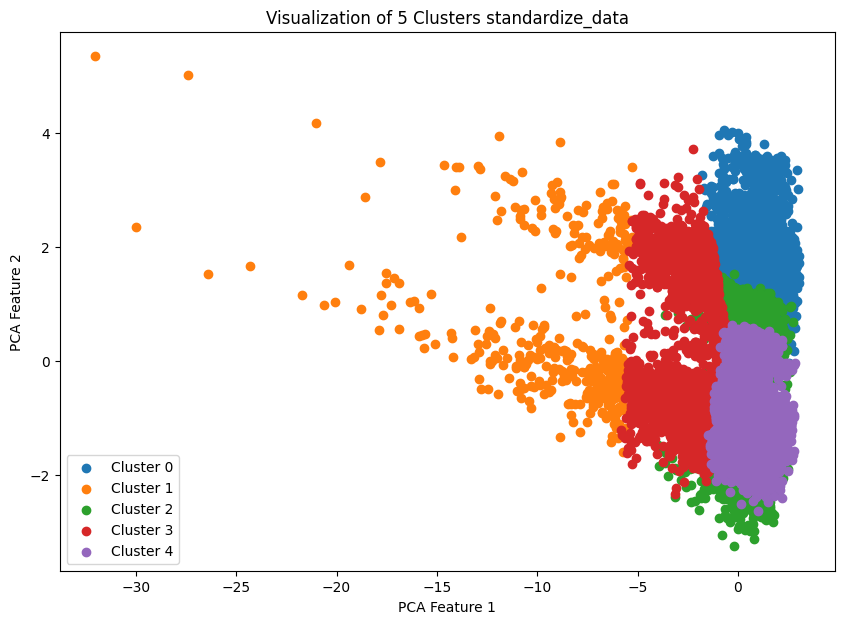

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.43476625013488734
Feature Contributions: [-0.07617924 -0.66201718]


Principal Component 2:
Explained Variance: 0.2135917249519701
Feature Contributions: [0.0758837 0.6905168]


Clustering Performance Metrics:
Silhouette Score: 0.42083262227005763
Within-Cluster Sum of Squares (WCSS): 82029.79900088112


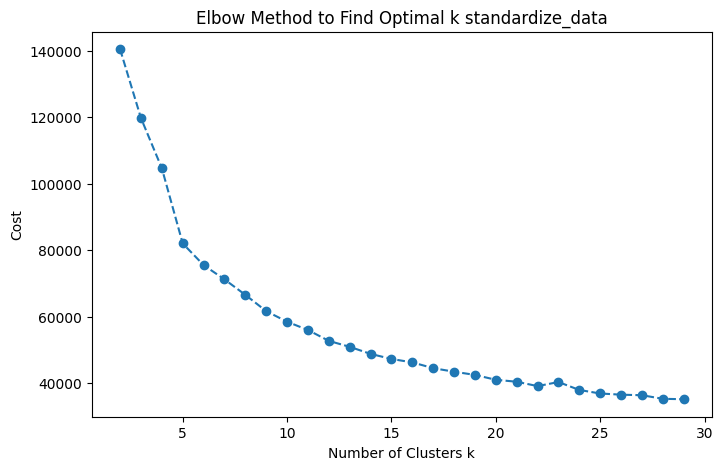

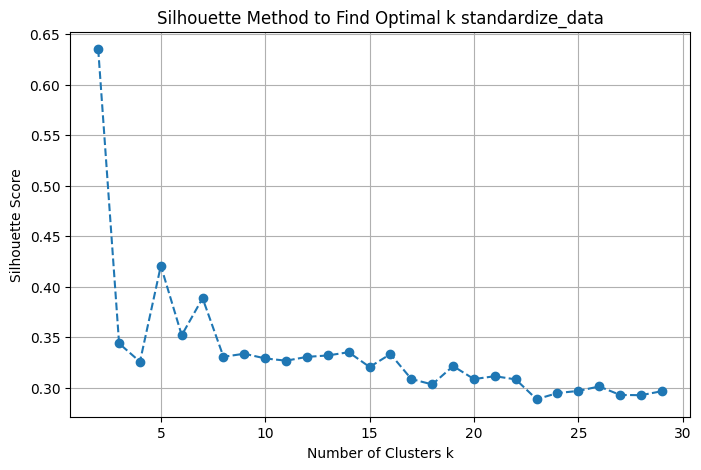

In [5]:
#Experiment 1 when only normalization is applied
#Applyì standardization
#This will help us remove unfair advantages in contribution some features have over others
fe_data = get_fe_data(data, remove_ocean_proximity=True)
exp_name = "standardize_data"
fe_data = assemble_features_vector(fe_data) #see difference between including oneHot encoded ocean proximity and not including it
fe_data = standardize_data(fe_data)

#fe_data = standardize_data_onehotencoded(fe_data, ['ocean_proximity']) #standardize, avoiding to standardize one hot encoded fiedls
fe_data.show(n=1, truncate=False)

plot_cluster(fe_data, 5, exp_name)
print_feature_engineering_results(fe_data, exp_name)

Time elapsed: 4.535101413726807 seconds


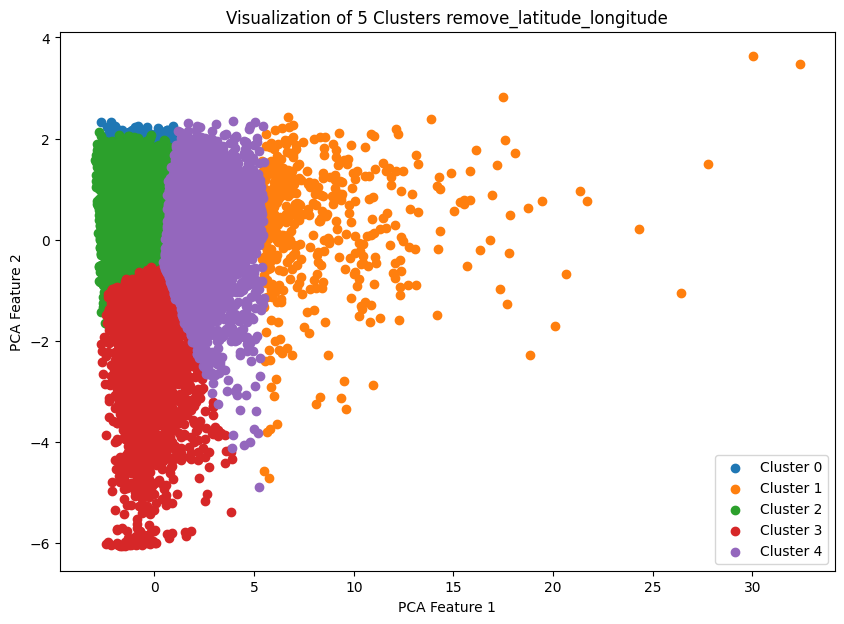

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.5069250595404067
Feature Contributions: [-0.21640219 -0.06429508]


Principal Component 2:
Explained Variance: 0.2292477129934218
Feature Contributions: [ 0.4884223  -0.06055461]


Clustering Performance Metrics:
Silhouette Score: 0.3179332433311634
Within-Cluster Sum of Squares (WCSS): 69231.88480432318


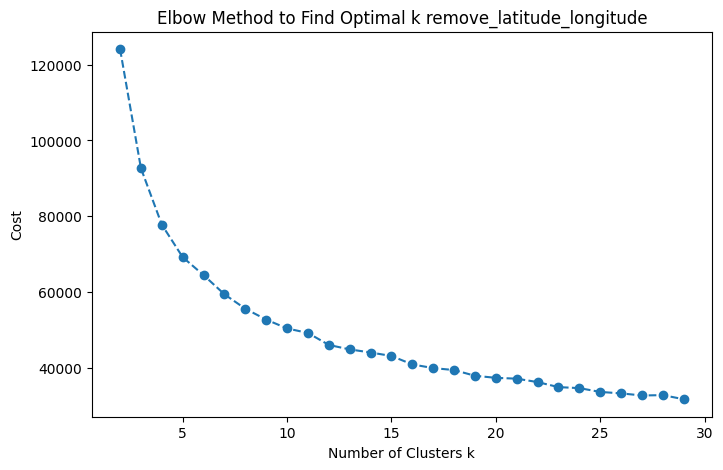

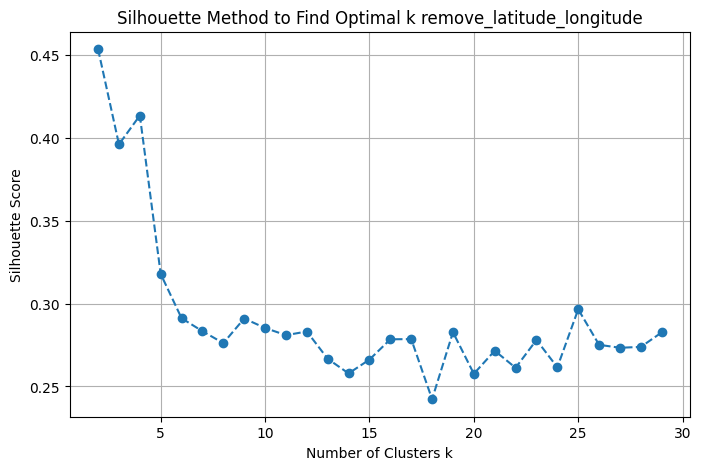

+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|latitude           |longitude         |features                                                                                                                                                                                        |
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------

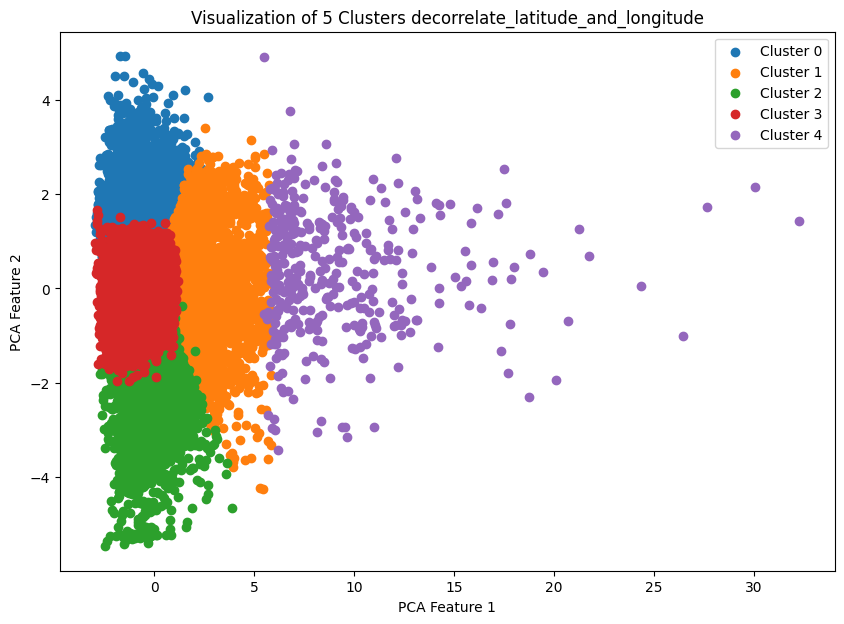

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.40302219952716345
Feature Contributions: [-0.21654851 -0.15560163]


Principal Component 2:
Explained Variance: 0.21971956530091358
Feature Contributions: [ 0.48718272 -0.03209808]


Clustering Performance Metrics:
Silhouette Score: 0.32532686910289904
Within-Cluster Sum of Squares (WCSS): 99781.38568379889


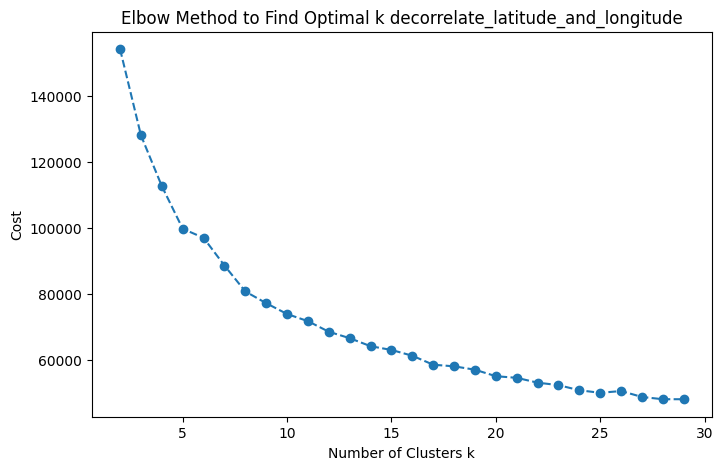

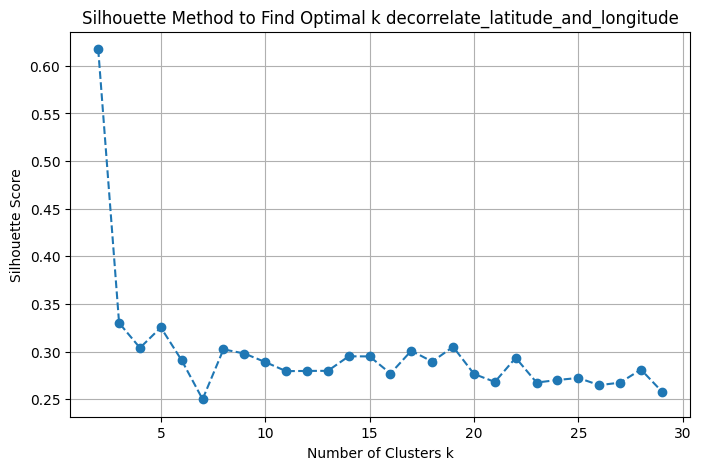

In [6]:
#Experiment 2: remove latitude and longitude
fe_data = get_fe_data(data)
exp_name = "remove_latitude_longitude"
fe_data = fe_data.drop('latitude', 'longitude')

fe_data = standardize_data_onehotencoded(fe_data, ['ocean_proximity'])

plot_cluster(fe_data, 5, exp_name)
print_feature_engineering_results(fe_data, exp_name)

#Experiment 2: decorrelate latitude and longitude
fe_data = get_fe_data(data)
exp_name = "decorrelate_latitude_and_longitude"
fe_data = decorrelate_features(fe_data, 'latitude', 'longitude')

fe_data = standardize_data_onehotencoded(fe_data, ['ocean_proximity'])
fe_data.show(n=1, truncate=False)
fe_data = fe_data.drop('latitude', 'longitude')

plot_cluster(fe_data, 5, exp_name)
print_feature_engineering_results(fe_data, exp_name)

+------------------+-----------+--------------+----------+----------+-------------+------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+------------------+-----------+--------------+----------+----------+-------------+------------------+
|41.0              |880.0      |129.0         |322.0     |126.0     |8.3252       |452600.0          |
+------------------+-----------+--------------+----------+----------+-------------+------------------+
only showing top 1 row



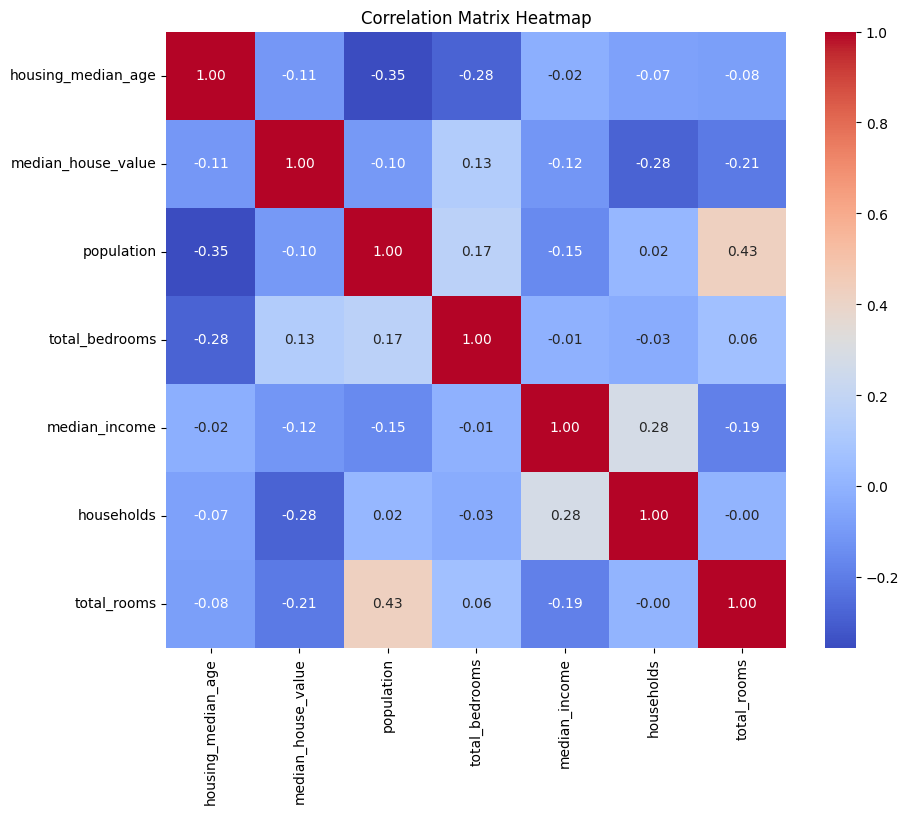

+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+----------------------------------------------------------------------------------------------------------------------------------------+
|housing_median_age|median_house_value|population       |total_bedrooms    |median_income    |households       |total_rooms      |features                                                                                                                                |
+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+----------------------------------------------------------------------------------------------------------------------------------------+
|41.0              |-452600.000065261 |949.7762225456713|3.0588494565636006|17.70807339690885|88.72379822910368|18.48018267089654|[0.9821392783837307,-2.128766550583294,-0.8650931065666871,1.05721

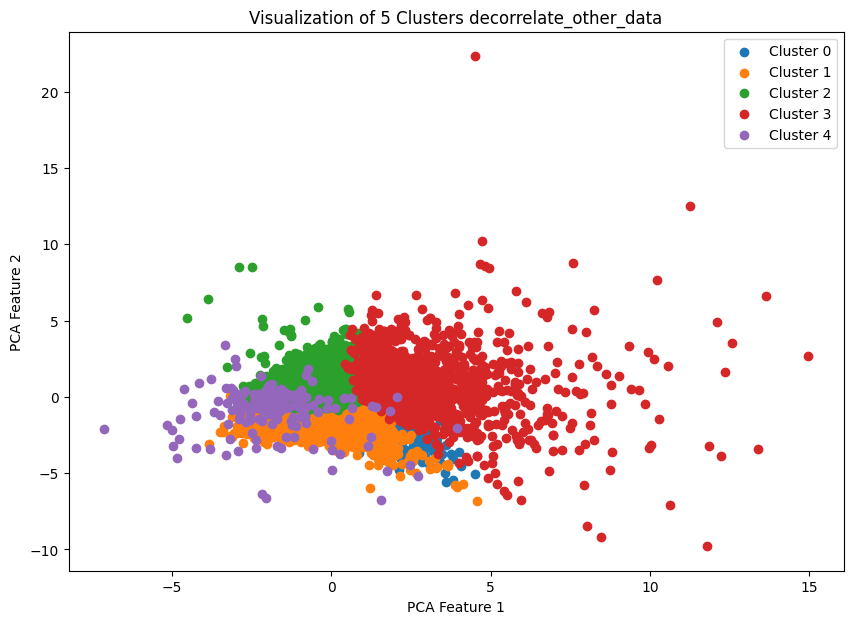

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.2516502309625629
Feature Contributions: [-0.45038512 -0.02628353]


Principal Component 2:
Explained Variance: 0.21099731981921813
Feature Contributions: [-0.05296057  0.61856359]


Clustering Performance Metrics:
Silhouette Score: 0.2859834987247575
Within-Cluster Sum of Squares (WCSS): 88696.90981341014


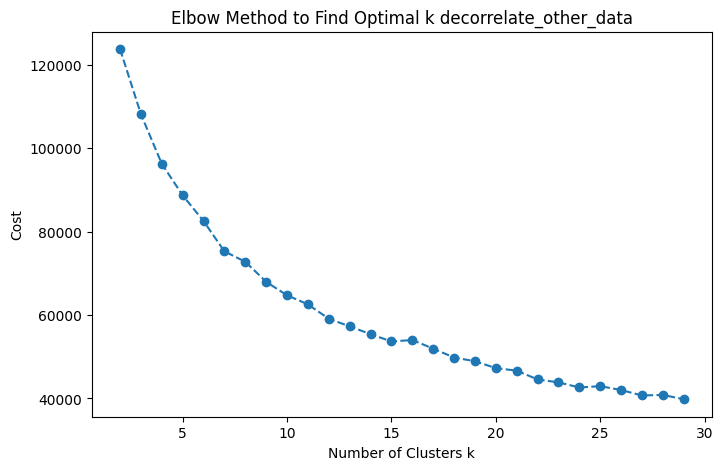

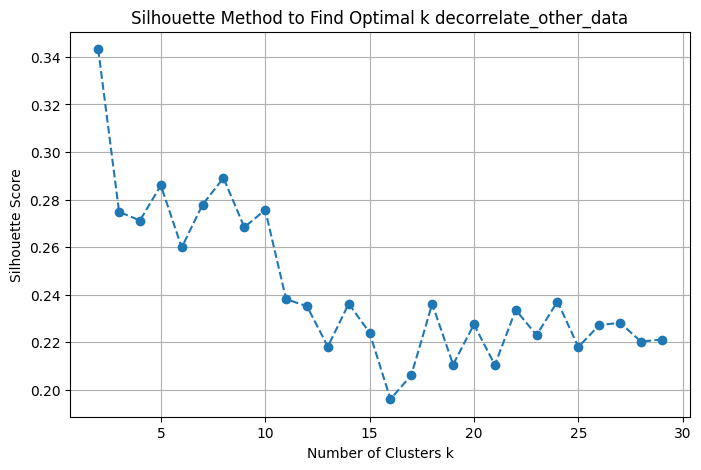

In [7]:
#Experiment 2: decorrelate other data
fe_data = get_fe_data(data, remove_latitude_longitude=True, remove_ocean_proximity=True)
exp_name = "decorrelate_other_data"

fe_data.show(n=1, truncate=False)
#Decorrelation makes the the two dimensions be orthogola on the plane. We try to achieve low correlation between each of the 4 features total_rooms, total_bedrooms, population and households, which are all highly correlated
#The final objective is to decorrelate every one of the 4 features from every other one of the four featues (correlation between -0.5 and 0.5)
#these decorrelation steps follow an incremental approach, where each time we test the changes in correlation caused by decorrelating two features
fe_data = decorrelate_features(fe_data, 'total_rooms', 'total_bedrooms') #the four features are highly correlated, so decorrelating two causes the others to be highly anticorrelated to the decorrelated features
fe_data = decorrelate_features(fe_data, 'population', 'households')
fe_data = decorrelate_features(fe_data, 'median_house_value', 'median_income')
fe_data = decorrelate_features(fe_data, 'population', 'total_rooms')
fe_data = decorrelate_features(fe_data, 'households', 'total_rooms')
fe_data = decorrelate_features(fe_data, 'median_income', 'total_bedrooms')
fe_data = decorrelate_features(fe_data, 'median_income', 'total_rooms')
fe_data = decorrelate_features(fe_data, 'households', 'total_rooms')

print_corr_matrix(fe_data) #we want to end with a correlation matrix where the features are not correlated or anti-correlated

fe_data = assemble_features_vector(fe_data)
fe_data = standardize_data(fe_data)
fe_data.show(n=1, truncate=False)

plot_cluster(fe_data, 5, exp_name)
print_feature_engineering_results(fe_data, exp_name)

+-----------+-------------+------------------+----------------------------------------------------------+
|total_rooms|median_income|median_house_value|features                                                  |
+-----------+-------------+------------------+----------------------------------------------------------+
|880.0      |8.3252       |452600.0          |[-0.8037929324103429,2.345105523071164,2.1287665504193685]|
+-----------+-------------+------------------+----------------------------------------------------------+
only showing top 1 row

Time elapsed: 2.5884242057800293 seconds


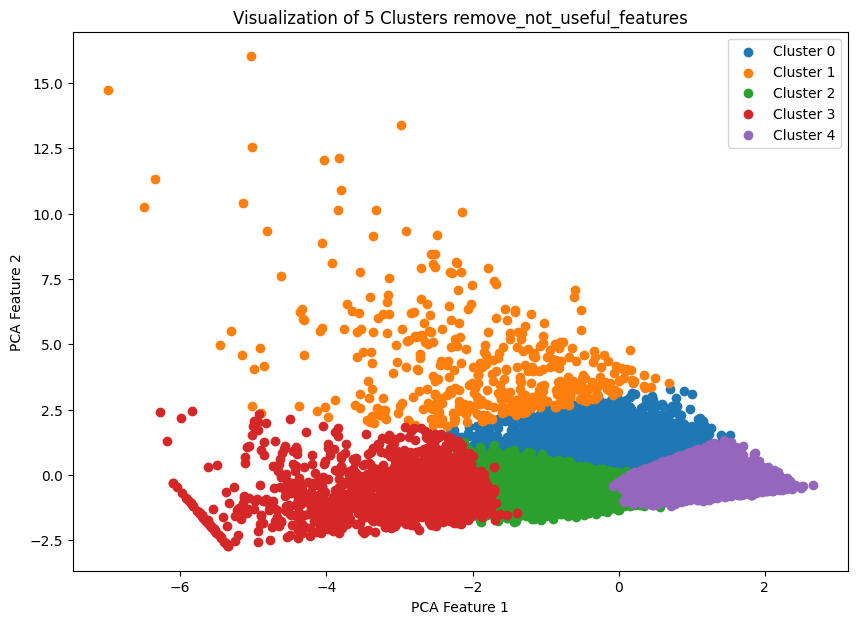

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.5868640476569393
Feature Contributions: [-0.29475277  0.95301427]


Principal Component 2:
Explained Variance: 0.3103210893615361
Feature Contributions: [-0.68222996 -0.15866259]


Clustering Performance Metrics:
Silhouette Score: 0.49193483160294066
Within-Cluster Sum of Squares (WCSS): 20168.06182284306


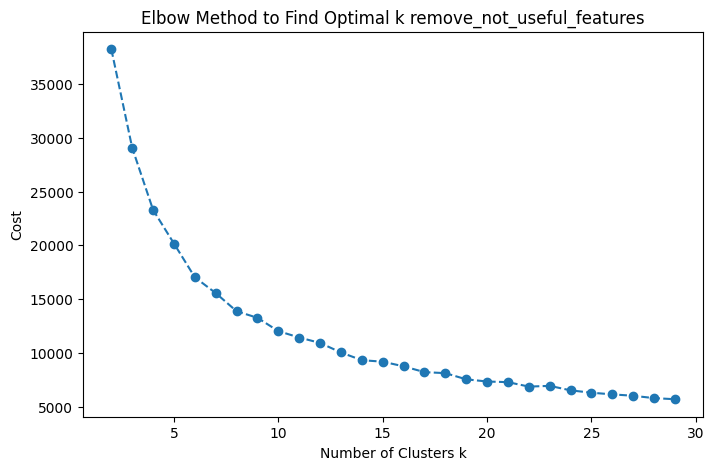

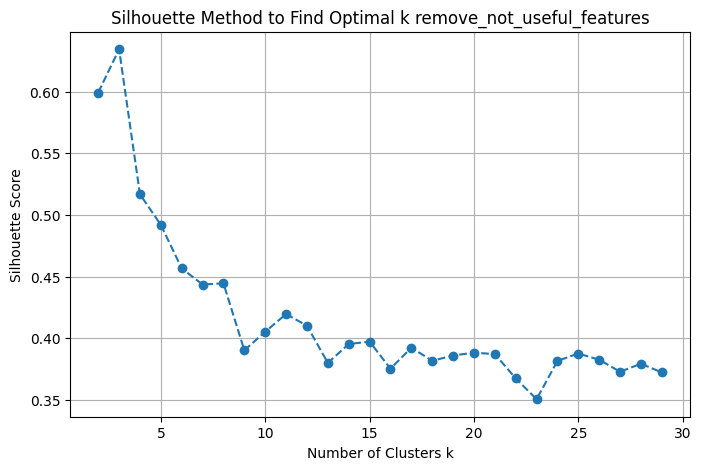

In [8]:
#Experiment 3
exp_name = "remove_not_useful_features"
fe_data = get_fe_data(data)
fe_data = fe_data.drop('latitude', 'longitude', 'housing_median_age', 'total_bedrooms', 'population','households', 'ocean_proximity') #removing housing_median_age helps too
fe_data = assemble_features_vector(fe_data)
fe_data = standardize_data(fe_data)
fe_data.show(n=1, truncate=False)

plot_cluster(fe_data, 5, exp_name)
print_feature_engineering_results(fe_data, exp_name)

+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------------------------------------------------------------------------------------------------------------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|features                                                                                                                                 |
+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------------------------------------------------------------------------------------------------------------------------+
|41.0              |880.0      |129.0         |322.0     |126.0     |8.3252       |452600.0          |[0.9821392783837307,-0.8037929324103429,-0.9703014690713359,-0.9732956984921853,-0.9768093686565708,2.345105523071164,2.1287665504193685]|
+------------------+-----------+----

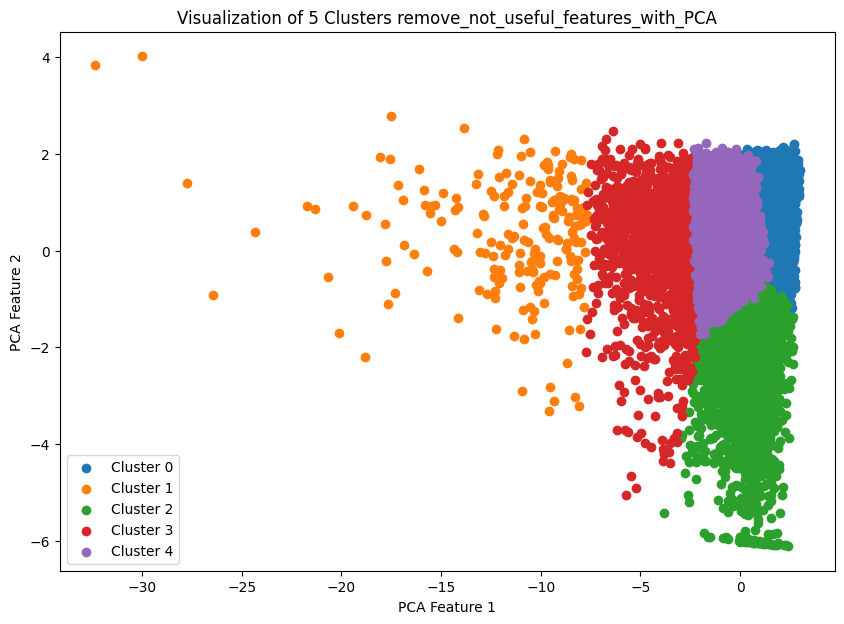

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.5988903773611406
Feature Contributions: [-1.00000000e+00  3.04259498e-16]


Principal Component 2:
Explained Variance: 0.2618699754110741
Feature Contributions: [3.04259498e-16 1.00000000e+00]


Clustering Performance Metrics:
Silhouette Score: 0.42262874136323103
Within-Cluster Sum of Squares (WCSS): 46522.923484054016


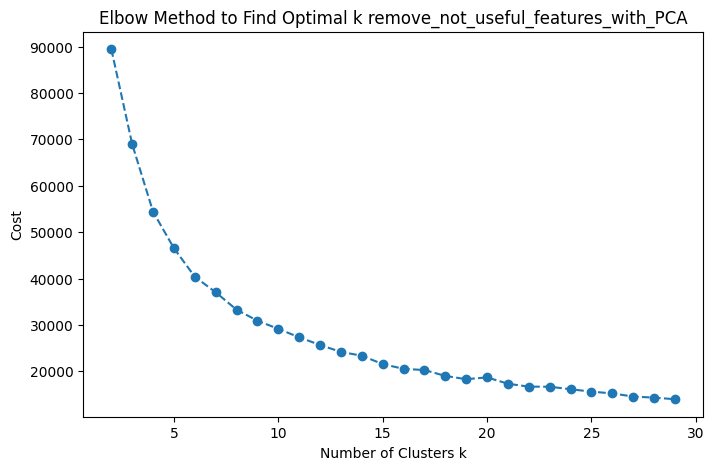

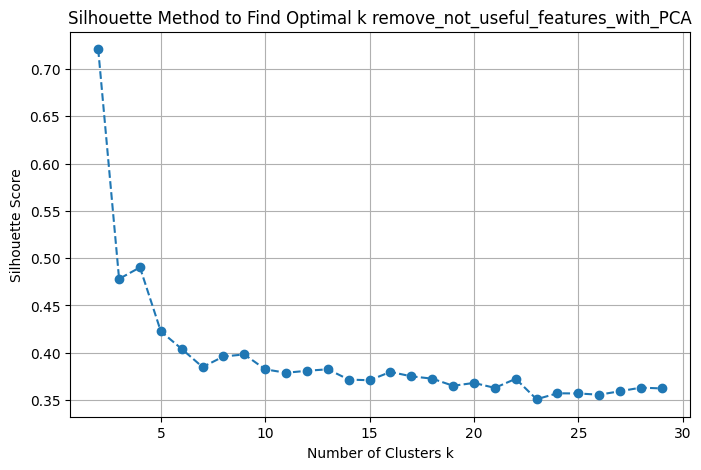

In [9]:
#Experiment 4
exp_name = "remove_not_useful_features_with_PCA"
fe_data = get_fe_data(data, remove_ocean_proximity=True, remove_latitude_longitude=True)

#asseemble vector and standardize it for PCA
fe_data = assemble_features_vector(fe_data)
fe_data = standardize_data(fe_data)
fe_data.show(n=1, truncate=False)

#Do PCA using 90% cumulative variance to find k most important components
r = find_top_dimensions_PCA(fe_data, 7) #the features vector has 7 dimensions in total
#found k=3

#Use PCA to project down to the k dimensions we have found to be most important
fe_data = apply_PCA(fe_data, 3)
fe_data.show(n=1, truncate=False)

plot_cluster(fe_data, 5, exp_name)
print_feature_engineering_results(fe_data, exp_name)

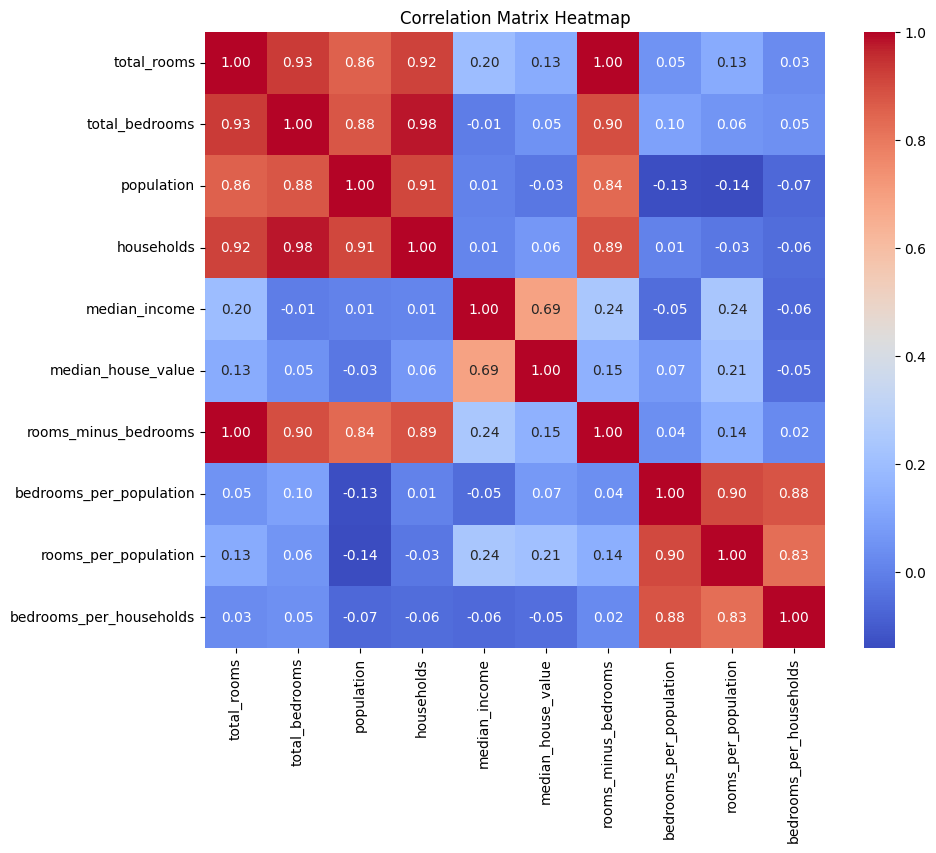

Explained variance is: [4.66311373e-01 2.79501010e-01 1.73868993e-01 3.81458808e-02
 2.06505791e-02 1.07440503e-02 6.86699479e-03 2.72528827e-03
 1.18583196e-03 3.50421051e-16]
Number of components selected for 90% explained variance: 3
+-----------+--------------+----------+----------+-------------+------------------+--------------------+-----------------------+--------------------+-----------------------+----------------------------------------------------------+
|total_rooms|total_bedrooms|population|households|median_income|median_house_value|rooms_minus_bedrooms|bedrooms_per_population|rooms_per_population|bedrooms_per_households|features                                                  |
+-----------+--------------+----------+----------+-------------+------------------+--------------------+-----------------------+--------------------+-----------------------+----------------------------------------------------------+
|880.0      |129.0         |322.0     |126.0     |8.3252       |

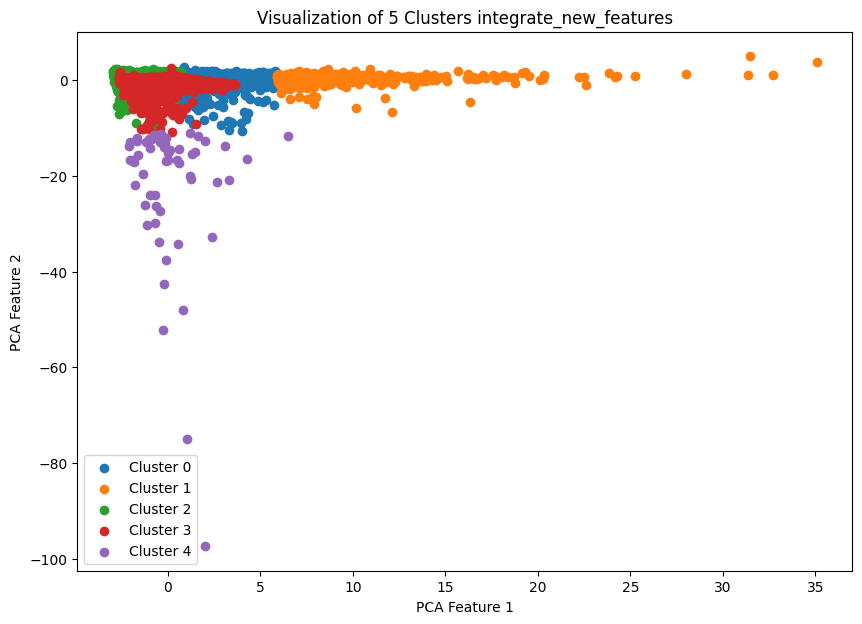

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.5070357900858551
Feature Contributions: [-1.00000000e+00 -7.64785463e-17]


Principal Component 2:
Explained Variance: 0.30391069919759645
Feature Contributions: [ 7.64785463e-17 -1.00000000e+00]


Clustering Performance Metrics:
Silhouette Score: 0.5342551090159399
Within-Cluster Sum of Squares (WCSS): 69329.1054960262


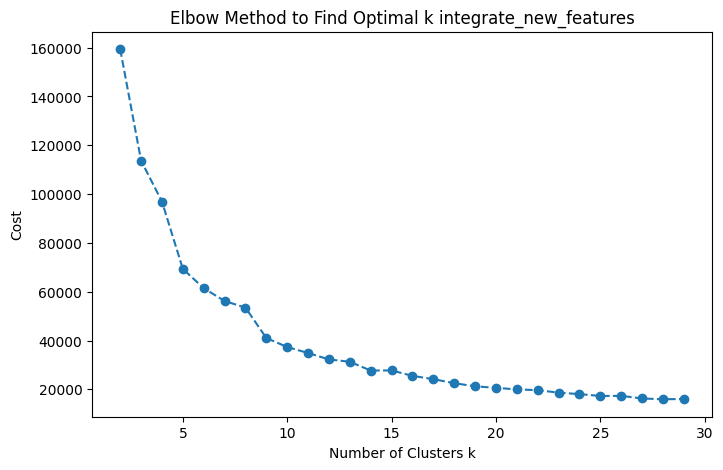

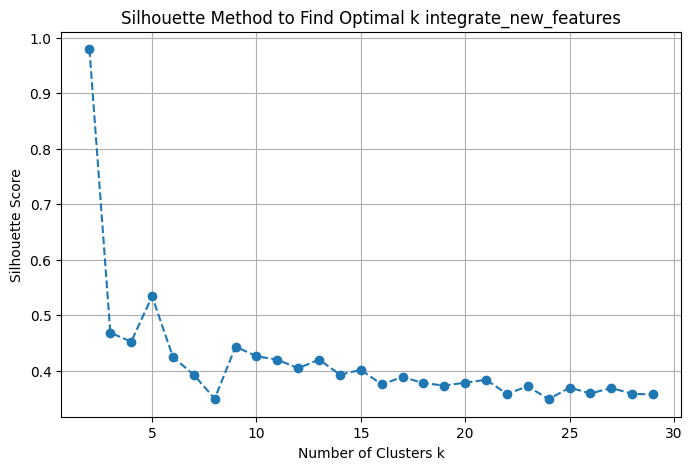

In [10]:
#Experiment 5
exp_name = "integrate_new_features"
fe_data = get_fe_data(data, remove_latitude_longitude=True, remove_ocean_proximity=True)
fe_data = fe_data.drop('housing_median_age')

fe_data = fe_data.withColumn("rooms_minus_bedrooms", col("total_rooms") - col("total_bedrooms"))
fe_data = fe_data.withColumn("bedrooms_per_population", col("total_bedrooms") / col("population"))
fe_data = fe_data.withColumn("rooms_per_population", col("total_rooms") / col("population"))
fe_data = fe_data.withColumn("bedrooms_per_households", col("total_bedrooms") / col("households"))

print_corr_matrix(fe_data)
fe_data = assemble_features_vector(fe_data)
fe_data = standardize_data(fe_data)

fe_data = apply_PCA(fe_data, find_top_dimensions_PCA(fe_data, 10))
fe_data.show(n=1, truncate=False)

plot_cluster(fe_data, 5, exp_name)
print_feature_engineering_results(fe_data, exp_name)

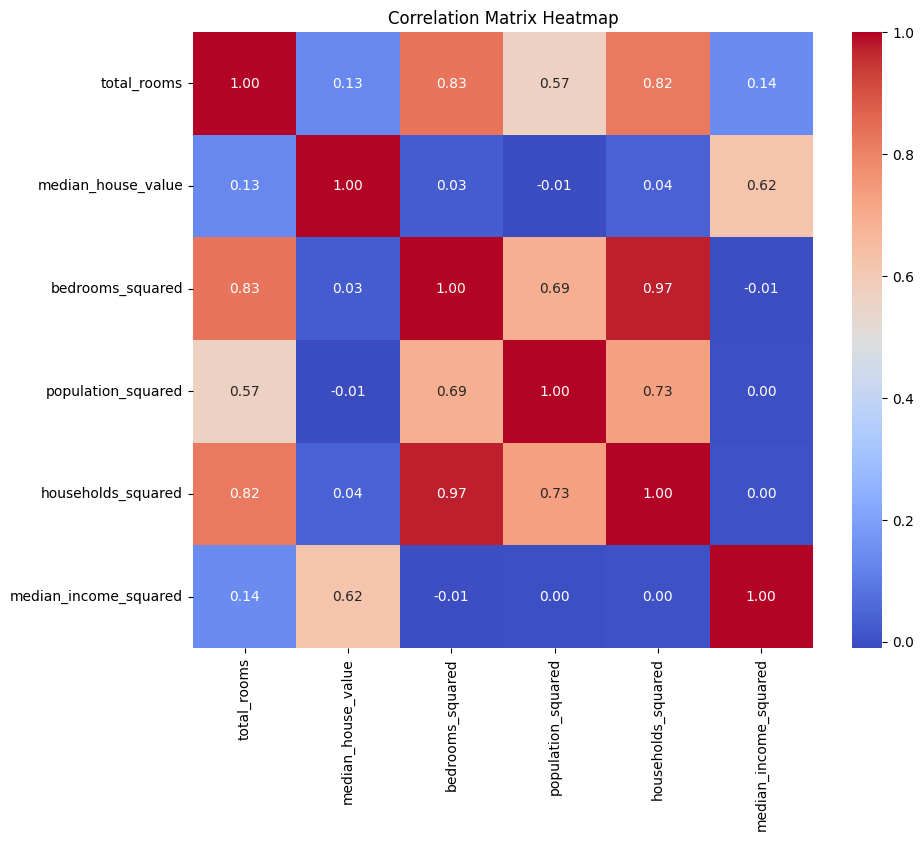

Explained variance is: [0.55510647 0.27279616 0.07495176 0.0629471  0.03034601 0.00385249]
Number of components selected for 90% explained variance: 3
+-----------+------------------+----------------+------------------+------------------+---------------------+------------------------------------------------------------+
|total_rooms|median_house_value|bedrooms_squared|population_squared|households_squared|median_income_squared|features                                                    |
+-----------+------------------+----------------+------------------+------------------+---------------------+------------------------------------------------------------+
|880.0      |452600.0          |16641.0         |103684.0          |15876.0           |69.30895504000001    |[0.6769662390798352,-3.1181630409829086,-0.5539588869659988]|
+-----------+------------------+----------------+------------------+------------------+---------------------+--------------------------------------------------------

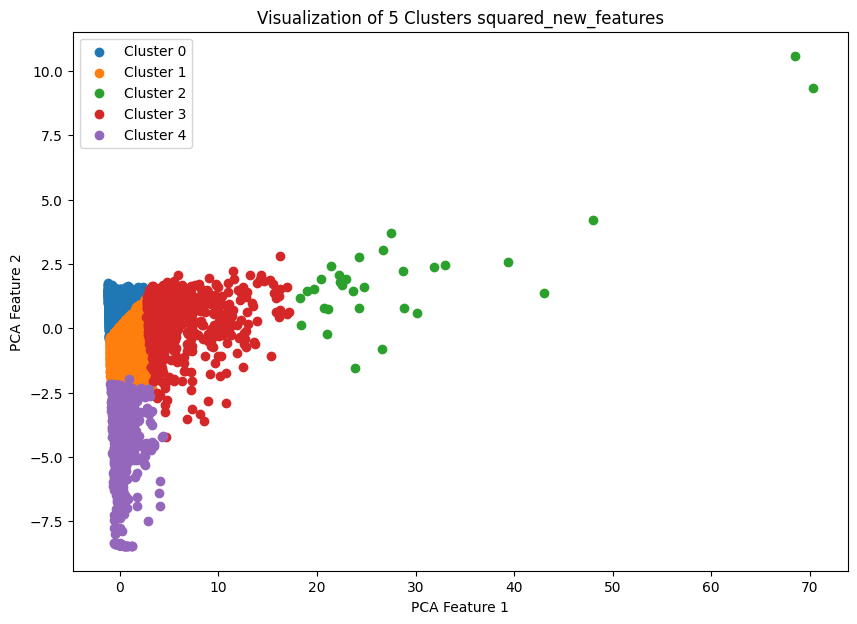

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.6148349897574157
Feature Contributions: [-1.00000000e+00  1.96847013e-16]


Principal Component 2:
Explained Variance: 0.30214856240883997
Feature Contributions: [1.96847013e-16 1.00000000e+00]


Clustering Performance Metrics:
Silhouette Score: 0.5649148701232231
Within-Cluster Sum of Squares (WCSS): 35996.545449694386


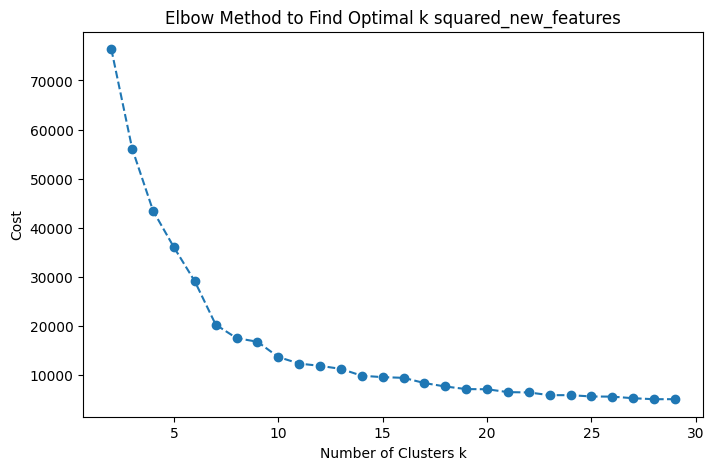

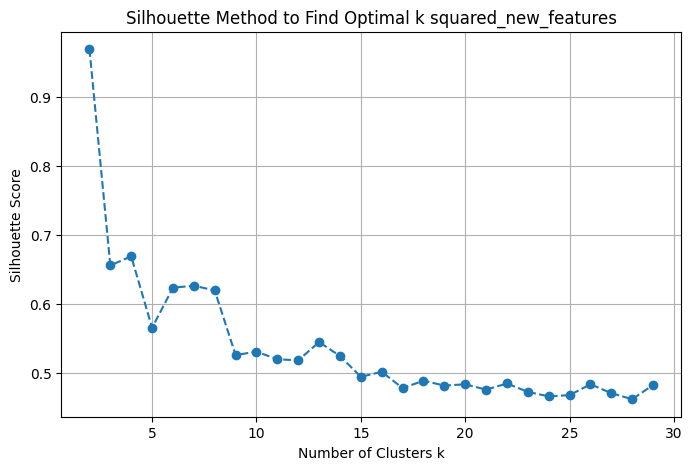

In [11]:
#Experiment 6
exp_name = "squared_new_features"
fe_data = get_fe_data(data, remove_ocean_proximity=True, remove_latitude_longitude=True)

fe_data = fe_data.withColumn("bedrooms_squared", col("total_bedrooms") ** 2)
fe_data = fe_data.withColumn("population_squared", col("population") ** 2)
fe_data = fe_data.withColumn("households_squared", col("households") ** 2)
fe_data = fe_data.withColumn("median_income_squared", col("median_income") ** 2)
fe_data = fe_data.withColumn("housing_median_age", col("housing_median_age") ** 2)
fe_data = fe_data.drop('total_bedrooms', 'population', 'households', 'median_income', 'housing_median_age')

print_corr_matrix(fe_data)

fe_data = assemble_features_vector(fe_data)
fe_data = standardize_data(fe_data)

fe_data = apply_PCA(fe_data, find_top_dimensions_PCA(fe_data, 6))
fe_data.show(n=1, truncate=False)

plot_cluster(fe_data, 5, exp_name)
print_feature_engineering_results(fe_data, exp_name)

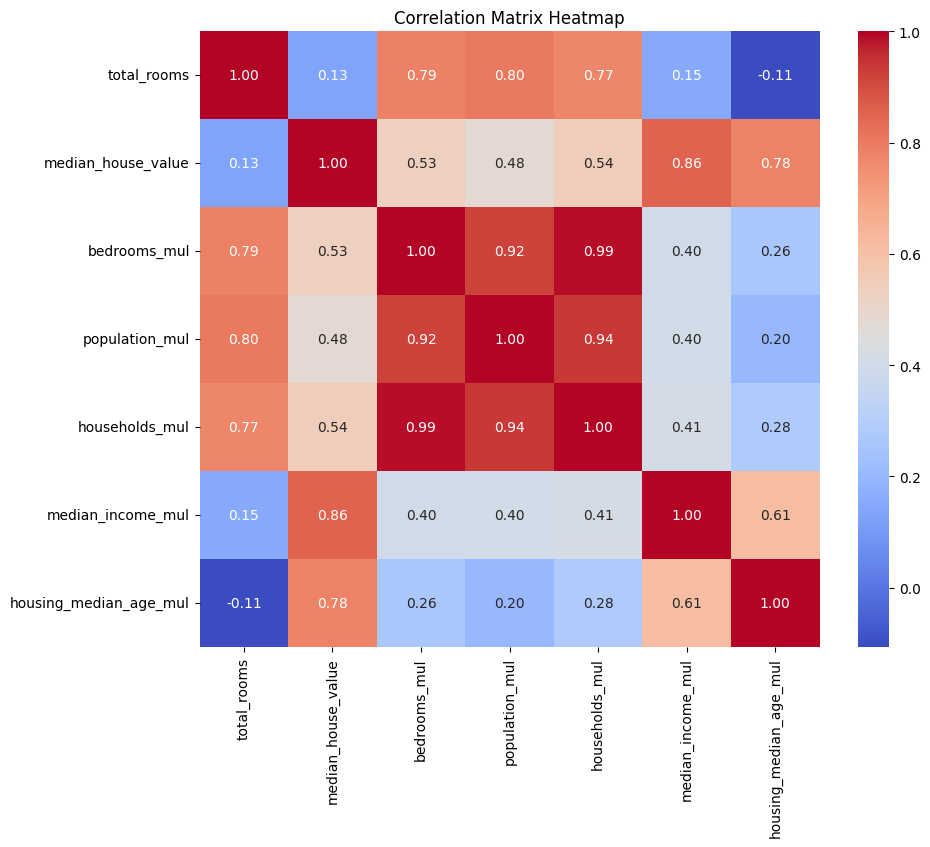

Explained variance is: [0.61704486 0.27715005 0.05545842 0.0270083  0.0130581  0.00920403]
Number of components selected for 90% explained variance: 3
+-----------+------------------+------------+--------------+--------------+------------------+----------------------+----------------------------------------------------------+
|total_rooms|median_house_value|bedrooms_mul|population_mul|households_mul|median_income_mul |housing_median_age_mul|features                                                  |
+-----------+------------------+------------+--------------+--------------+------------------+----------------------+----------------------------------------------------------+
|880.0      |452600.0          |5.83854E7   |1.457372E8    |5.70276E7     |3767985.5200000005|1.85566E7             |[-1.3226477164641264,-4.16950511345706,0.6221250405982072]|
+-----------+------------------+------------+--------------+--------------+------------------+----------------------+------------------------

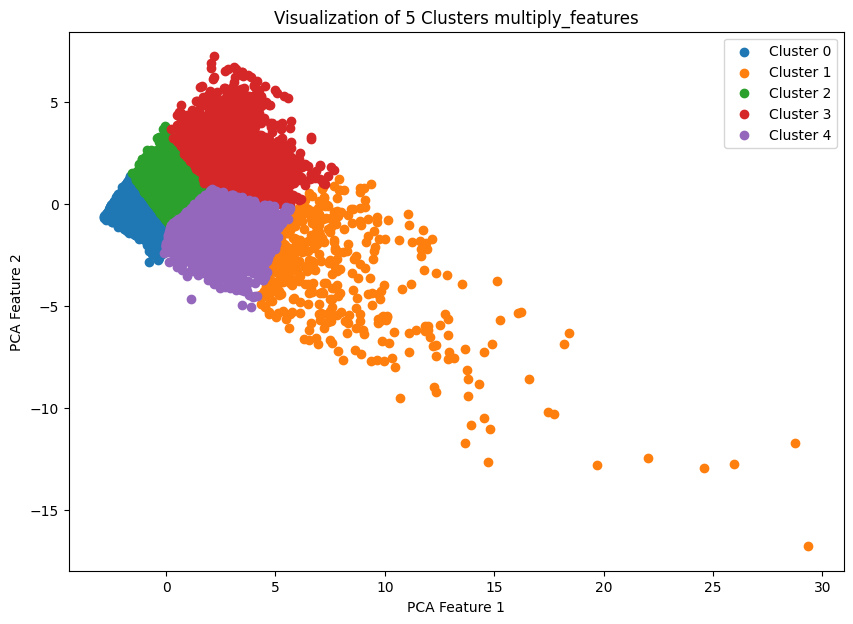

PCA Components (Feature Contributions):
Principal Component 1:
Explained Variance: 0.6497580085396135
Feature Contributions: [-1.00000000e+00 -3.74414377e-16]


Principal Component 2:
Explained Variance: 0.2918433930737115
Feature Contributions: [ 3.74414377e-16 -1.00000000e+00]


Clustering Performance Metrics:
Silhouette Score: 0.5325522672242343
Within-Cluster Sum of Squares (WCSS): 39010.36209766859


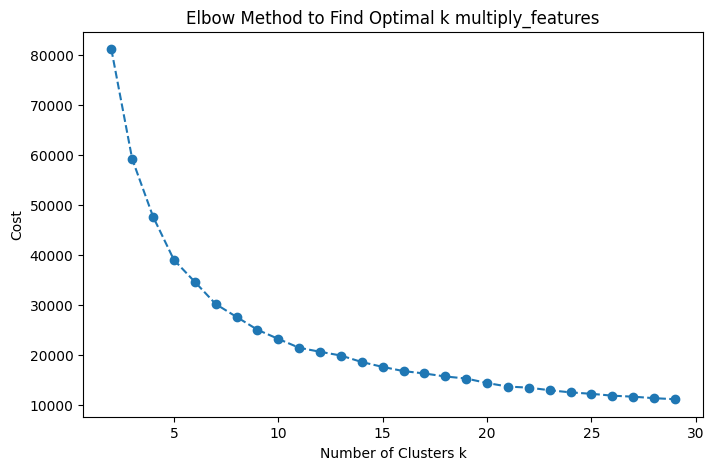

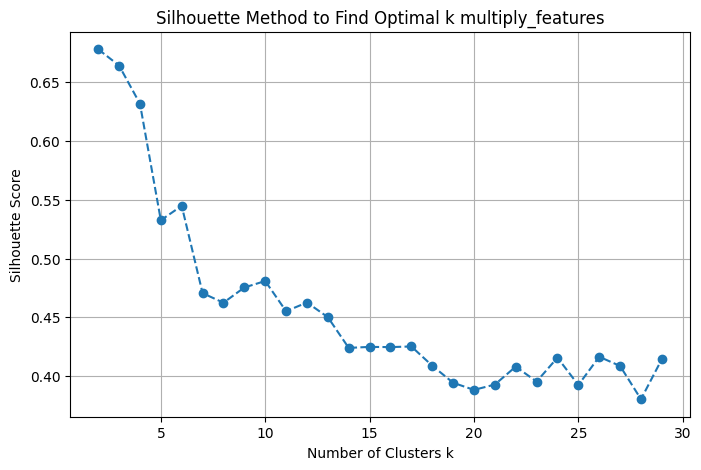

In [12]:
#Experiment 7
exp_name = "multiply_features"
fe_data = get_fe_data(data, remove_ocean_proximity=True, remove_latitude_longitude=True)

fe_data = fe_data.withColumn("bedrooms_mul", col("total_bedrooms") * col("median_house_value"))
fe_data = fe_data.withColumn("population_mul", col("population") * col("median_house_value"))
fe_data = fe_data.withColumn("households_mul", col("households") * col("median_house_value"))
fe_data = fe_data.withColumn("median_income_mul", col("median_income") * col("median_house_value"))
fe_data = fe_data.withColumn("housing_median_age_mul", col("housing_median_age") * col("median_house_value"))
fe_data = fe_data.drop('total_bedrooms', 'population', 'households', 'median_income', 'housing_median_age')

print_corr_matrix(fe_data)
fe_data = assemble_features_vector(fe_data)
fe_data = standardize_data(fe_data)

fe_data = apply_PCA(fe_data, find_top_dimensions_PCA(fe_data, 6))
fe_data.show(n=1, truncate=False)

plot_cluster(fe_data, 5, exp_name)
print_feature_engineering_results(fe_data, exp_name)
